In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

# Import necessary modules
from scipy import io
from scipy.stats import pearsonr

import numpy as np
import pandas as pd
import seaborn as sns

from neurodsp import spectral
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_times

from fooof import FOOOF
from fooof.analysis import get_band_peak_fm

from bycycle.features import compute_features
from bycycle.group import compute_features_2d
from bycycle.plts import plot_burst_detect_summary, plot_feature_categorical
from bycycle.utils import flatten_dfs

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt

/var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/ipykernel_24195/3528540022.py:17: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


/var/folders/s6/21s_2dfj2f195fl1lglp7jrw0000gn/T/ipykernel_24195/4133755511.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq_mean), np.log10(P_mean))


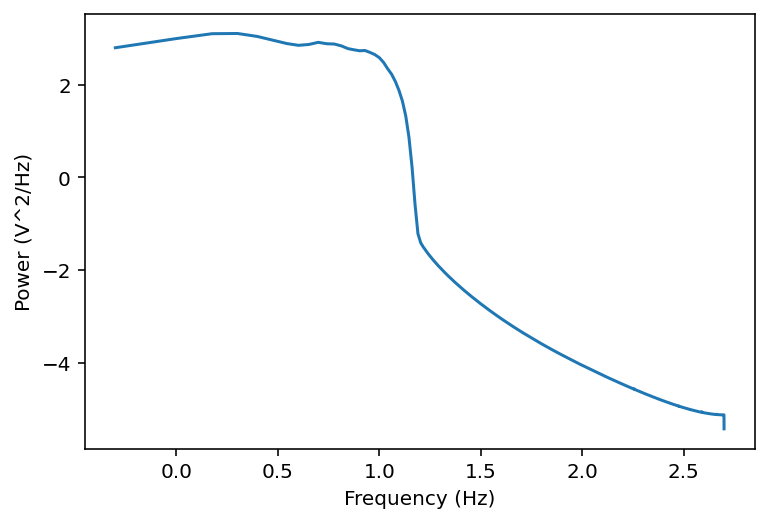

[  0.    0.5   1.  ... 499.  499.5 500. ]
[ 2.13746488  2.80198333  3.000594   ... -5.12747133 -5.12747559
 -5.42900857]


In [11]:
# Load the text file as a 1D numpy array directly using the file path
# load the visual cortical ECoG channel, and the event indices

#data = io.loadmat('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Dyad1Exp2/Dyad1Exp2vOBrrByMousePost.mat', squeeze_me=True)
data = np.loadtxt('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Dyad1Exp2/Dyad1Exp2_bymousePost.txt') 
scaled_data = data * 100

fs = 1000 #originally 30,000 - previously downsampled

# Calculate power spectra
freq_mean, P_mean = spectral.compute_spectrum(scaled_data, fs, method='welch', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)
# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='welch')

# Plot PSD
plt.plot(np.log10(freq_mean), np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
#plt.xlim((1, 50))
#plt.ylim((-8, 5))
plt.show()

print(freq_mean)
print(np.log10(P_mean))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.10 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

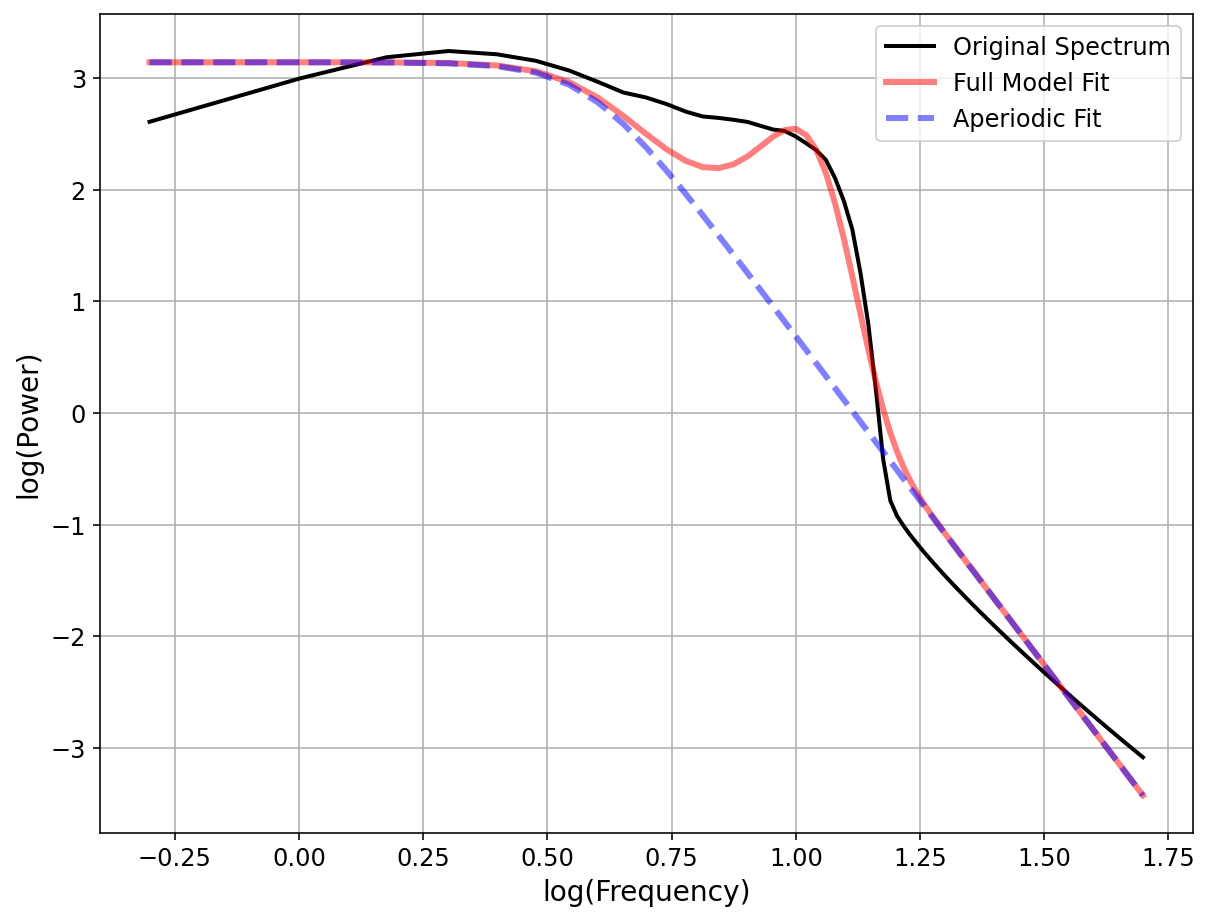

In [3]:
# Initialize a FOOOF object
fm = FOOOF(max_n_peaks = 1, peak_width_limits=[0.1, 50.0], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.5, 50]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freq_mean, P_mean, freq_range, plt_log=True)

In [7]:
F_RANGE = (4, 12)
preprocess_f_range = (0.5, 30)

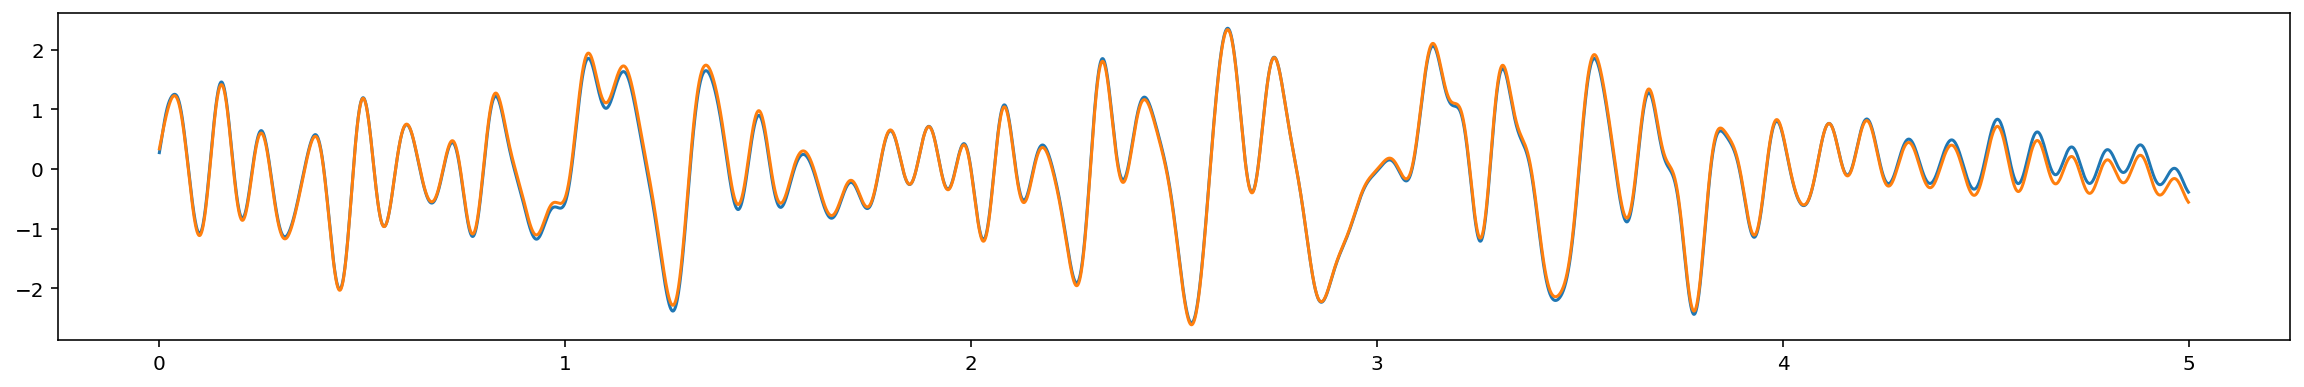

In [12]:
# Preprocessing
preproc_sig = filter_signal(data, fs, 'bandpass', preprocess_f_range, remove_edges=False)
preproc_sig2 = filter_signal(data, fs, 'bandpass', F_RANGE, remove_edges=False)

# Plot raw and preprocessed signal
%matplotlib inline
times = create_times(len(preproc_sig) / fs, fs)
plt.figure(figsize=(20,3))
plt.plot(times[0:5000], preproc_sig[0:5000])
plt.plot(times[0:5000], data[0:5000])
plt.show()

In [13]:
# Tuned burst detection parameters
threshold_kwargs = {'amp_fraction_threshold': 0.1,
                    'amp_consistency_threshold': 0.2,
                    'period_consistency_threshold': 0.35,
                    'monotonicity_threshold': 0.85,
                    'min_n_cycles': 3}

# Compute waveform shape features
#df_bycycle_2Post = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_2Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_2ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_2ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_ByPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_ByPre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
df_bycycle_ByStanderPost = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)
#df_bycycle_Pre = compute_features(preproc_sig, fs, F_RANGE, threshold_kwargs=threshold_kwargs)  

In [14]:
df_bycycle_Post.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/Dyad1Exp2/bycycle_ByStanderPost.txt', sep='\t', index=False)

In [54]:
preproc_sig

array([-0.20948714, -0.2237349 , -0.23730225, ...,  0.27385789,
        0.26137286,  0.24601495])

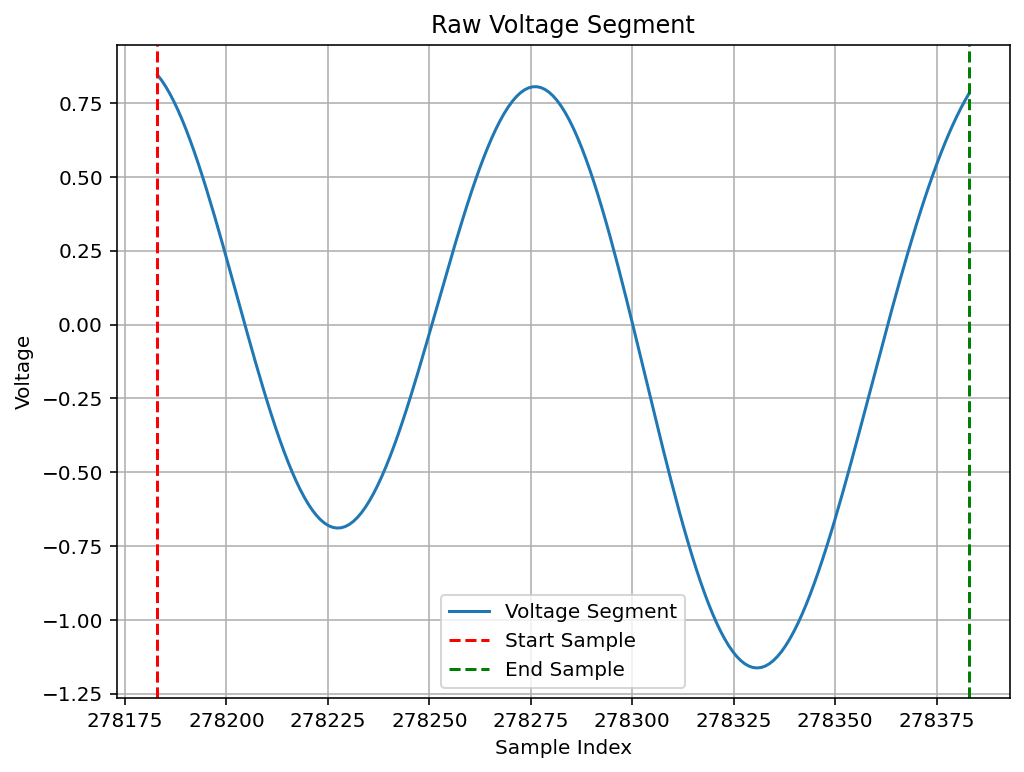

In [43]:
##for monique 
def plot_raw_segment(voltage_array, start_sample, end_sample):
    """
    Plot a raw segment from the voltage array based on start and end sample indices.

    Parameters:
        voltage_array (np.ndarray): 1D array of voltage values.
        start_sample (int): The start sample index for the segment.
        end_sample (int): The end sample index for the segment.

    Returns:
        None
    """
    # Extract the segment from the voltage array using the start and end indices
    segment = preproc_sig2[start_sample:end_sample]
    
    # Create a time axis based on the number of samples
    time = np.linspace(start_sample, end_sample, len(segment))
    
    # Plot the raw segment
    plt.figure(figsize=(8, 6))
    plt.plot(time, segment, label="Voltage Segment")
    plt.axvline(x=start_sample, color='r', linestyle='--', label="Start Sample")
    plt.axvline(x=end_sample, color='g', linestyle='--', label="End Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("Voltage")
    plt.title("Raw Voltage Segment")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
start_sample = 278183  # Specify the start sample index
end_sample = 278383    # Specify the end sample index

# Plot the raw segment from the voltage data
plot_raw_segment(preproc_sig2, start_sample=start_sample, end_sample=end_sample)

In [125]:
def extract_and_store_segments(voltage_array, peaks_df, window_duration, sampling_frequency):
    """
    Extract segments of EEG data around peaks and store them with metadata.

    Parameters:
        voltage_array (np.ndarray): 1D array of voltage values.
        peaks_df (pd.DataFrame): DataFrame containing peak sample indices in a column named 'peak_sample'.
        window_duration (float): Duration of the window in seconds.
        sampling_frequency (int): Sampling frequency of the data in Hz.

    Returns:
        pd.DataFrame: DataFrame containing extracted segments and metadata.
    """
    # Calculate the window size in samples
    window_samples = int(window_duration * sampling_frequency)

    # Create a list to store segment data
    segments = []

    valid_peaks = [
    peak_sample for peak_sample in peak_samples
    if (peak_sample - window_samples // 2 >= 0) and
       (peak_sample + window_samples // 2 <= len(voltage_array))]

    for peak_sample in valid_peaks:
        
        # Calculate start and end indices
        start_sample = max(peak_sample - window_samples // 2, 0)  # Ensure within bounds
        end_sample = min(peak_sample + window_samples // 2, len(voltage_array))  # Ensure within bounds
        
        # Extract segment and corresponding time values
        segment = voltage_array[start_sample:end_sample]
        time = np.linspace(start_sample / sampling_frequency, 
                           end_sample / sampling_frequency, 
                           len(segment))
        
        # Append metadata and segment to list
        segments.append({
            'peak_sample': peak_sample,
            'start_sample': start_sample,
            'end_sample': end_sample,
            'time': time,
            'segment': segment
        })

    # Convert to a DataFrame for structured storage
    segments_df = pd.DataFrame(segments)
    return segments_df


# Filter the DataFrame where 'is_burst' is True
peaks_df = df_bycycle_2ByPost[df_bycycle_2ByPost['is_burst'] == True]

# Parameters
sampling_frequency = 1000  # Sampling frequency in Hz
window_duration = 1        # 5-second window

# Extract segments and store in a DataFrame
segments_df = extract_and_store_segments(preproc_sig2, peaks_df, window_duration, sampling_frequency)

# Inspect the resulting DataFrame
print(segments_df)

      peak_sample  start_sample  end_sample  \
0            1365           865        1865   
1            1496           996        1996   
2            1689          1189        2189   
3            1825          1325        2325   
4            2552          2052        3052   
...           ...           ...         ...   
8269      1796315       1795815     1796815   
8270      1799086       1798586     1799586   
8271      1799203       1798703     1799703   
8272      1799385       1798885     1799885   
8273      1799485       1798985     1799985   

                                                   time  \
0     [0.865, 0.866001001001001, 0.867002002002002, ...   
1     [0.996, 0.997001001001001, 0.998002002002002, ...   
2     [1.189, 1.1900010010010011, 1.191002002002002,...   
3     [1.325, 1.326001001001001, 1.327002002002002, ...   
4     [2.052, 2.053001001001001, 2.0540020020020022,...   
...                                                 ...   
8269  [1795.815, 1795.

In [151]:
# Create a list to store segment data
segments = []

for peak_sample in min_time_decay:
    # Calculate the window size in samples
    window_duration = 1
    window_samples = int(window_duration * fs)
        
    # Calculate start and end indices
    start_sample = max(peak_sample - window_samples // 2, 0)  # Ensure within bounds
    end_sample = min(peak_sample + window_samples // 2, len(preproc_sig2))  # Ensure within bounds
    
    # Extract segment and corresponding time values
    segment = preproc_sig2[start_sample:end_sample]
    time = np.linspace(start_sample / sampling_frequency, 
                   end_sample / sampling_frequency, 
                   len(segment))
    
    # Append metadata and segment to list
    segments.append({
    'peak_sample': peak_sample,
    'start_sample': start_sample,
    'end_sample': end_sample,
    'time': time,
    'segment': segment
    })

# Convert to a DataFrame for structured storage
segments_df2 = pd.DataFrame(segments)
segments_df2

,peak_sample,start_sample,end_sample,time,segment
0,1379979,1379479,1380479,"[1379.479, 1379.480001001001, 1379.48100200200...","[-0.45359205418345194, -0.43553138746948655, -..."
1,42266,41766,42766,"[41.766, 41.767001001001, 41.768002002002, 41....","[-0.12811788778331504, -0.09336871660528878, -..."
2,1320002,1319502,1320502,"[1319.502, 1319.503001001001, 1319.50400200200...","[-0.6388613915518971, -0.6571087388369572, -0...."
3,200121,199621,200621,"[199.621, 199.62200100100102, 199.623002002002...","[0.05867116994278289, 0.10383181356948612, 0.1..."
4,240003,239503,240503,"[239.503, 239.504001001001, 239.505002002002, ...","[-0.4616189168361986, -0.4546400831258135, -0...."
5,10896,10396,11396,"[10.396, 10.397001001001001, 10.39800200200200...","[-0.14955699911443163, -0.15496581132339218, -..."
6,329627,329127,330127,"[329.127, 329.128001001001, 329.12900200200204...","[0.6332320661700913, 0.592187865798154, 0.5490..."
7,436507,436007,437007,"[436.007, 436.008001001001, 436.00900200200203...","[0.17687943249143417, 0.20736536732877142, 0.2..."
8,684381,683881,684881,"[683.881, 683.882001001001, 683.883002002002, ...","[0.5414965134972914, 0.5954194070828152, 0.647..."
9,685117,684617,685617,"[684.617, 684.618001001001, 684.6190020020019,...","[0.10515328001458499, 0.12136357608246276, 0.1..."


In [86]:
peaks_df

,amp_fraction,amp_consistency,period_consistency,monotonicity,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,...,time_rdsym,time_ptsym,band_amp,sample_peak,sample_last_zerox_decay,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,is_burst
2006,1.000000,0.428452,0.683544,1.000000,158,74,49,3.674348,-0.948719,100,...,0.367089,0.601626,1.910080,278283,278204,278327,278253,278225,278383,True
1943,0.999851,0.329617,0.592593,1.000000,162,75,93,2.727414,-2.683613,70,...,0.567901,0.446429,2.030072,269190,269055,269223,269148,269098,269260,True
4896,0.999702,0.585176,0.917526,1.000000,97,48,57,1.651158,-4.346850,42,...,0.567010,0.457143,2.267769,655355,655270,655375,655327,655300,655397,True
6169,0.999553,0.793874,0.689655,1.000000,120,56,59,2.679969,-2.500155,63,...,0.475000,0.486957,2.440218,824853,824765,824880,824824,824796,824916,True
2063,0.999404,0.340528,0.570552,1.000000,163,79,75,2.367564,-2.508128,90,...,0.447853,0.512987,2.085807,286737,286625,286779,286700,286664,286827,True
238,0.999107,0.864613,0.440329,0.921053,243,79,132,2.616896,-2.189920,110,...,0.547325,0.374408,1.476365,33594,33426,33637,33558,33461,33704,True
6175,0.998958,0.808699,0.493878,1.000000,121,58,124,2.159257,-2.924449,60,...,0.504132,0.318681,2.383924,825721,825567,825749,825691,825660,825781,True
1785,0.998660,0.756499,0.720000,1.000000,162,69,69,2.391149,-2.088393,100,...,0.382716,0.500000,1.997758,247333,247233,247371,247302,247271,247433,True
1640,0.998511,0.670306,0.645631,1.000000,206,122,53,2.143855,-1.958334,146,...,0.291262,0.697143,1.361989,226208,226122,226297,226175,226148,226354,True
623,0.998362,0.280357,0.409266,1.000000,259,100,62,2.602432,-2.030196,192,...,0.258687,0.617284,0.910171,88669,88572,88734,88634,88602,88861,True


In [66]:
segments = segments_df['segment']
segments

0       [-1.1753266487807508, 0.3394855939447603, -0.1...
1       [0.10946702674722092, -0.05957222430524501, -0...
2       [0.45500119446019843, -0.26855097413993745, -1...
3       [-0.46296591443640756, 1.507155044722812, 0.27...
4       [-0.3345902539194418, 1.1393060224619695, 1.02...
                              ...                        
2367    [1.482235106260113, 0.473147394137782, 0.44052...
2368    [0.05624808227179787, -0.9154669974405083, 0.1...
2369    [0.5246326291656419, 0.6382950059958298, 0.016...
2370    [-0.9119300667346262, -0.23094132788606506, 2....
2371    [1.2000226128628777, -0.6891842400920576, 0.58...
Name: segment, Length: 2372, dtype: object

In [148]:
max_time_peak = peaks_df.nlargest(10, 'time_peak')['sample_peak']
min_period = peaks_df.nsmallest(10, 'period')['sample_peak']
min_time_rise = peaks_df.nsmallest(10, 'time_rise')['sample_peak']
min_time_decay = peaks_df.nsmallest(10, 'time_decay')['sample_peak']

In [129]:
max_time_peak

12800    1595033
14179    1771262
11515    1435101
9522     1194098
10020    1254098
5935      730566
6183      763210
4437      537016
6140      755733
1376      158884
Name: sample_peak, dtype: int64

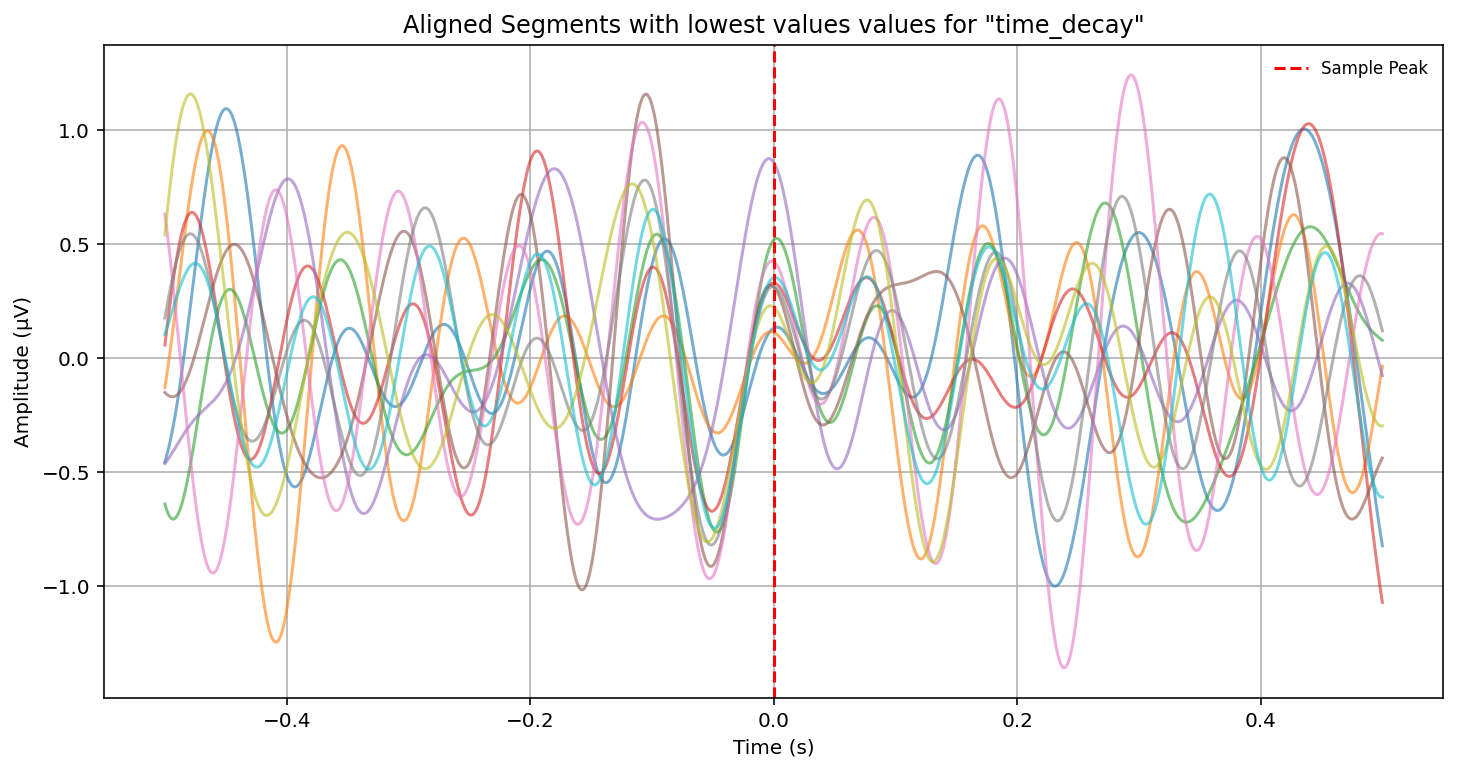

In [153]:
# Assuming the DataFrame is named `segments_df` and has a column `segment` with the aligned segments
# Each `segment` is an array of voltage values, and you have a consistent sampling rate
sampling_rate = 1000  # Hz
window_duration = 0.5  # seconds on each side
time_vector = np.linspace(-window_duration, window_duration, int(window_duration * 2 * sampling_rate))

plt.figure(figsize=(12, 6))

# Iterate over the segments in the DataFrame and plot each one
for i, segment in enumerate(segments_df2['segment']):

        plt.plot(time_vector, segment, alpha=0.6)  # Limit labels for clarity

# Add labels and customization
plt.title('Aligned Segments with lowest values values for "time_decay"')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  # Mark the reference peak
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Iterate over the segments in the DataFrame and plot each one
for i, segment in enumerate(segments_df['segment']):
    if 1000 > i > 990:
        plt.plot(time_vector, segment, alpha=0.6, label=f'Segment {i+1}' if i < 10 else None)  # Limit labels for clarity

# Add labels and customization
plt.title('Aligned Segments')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axvline(x=0, color='red', linestyle='--', label='Sample Peak')  # Mark the reference peak
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(True)
plt.show()

In [60]:
# Filter the DataFrame where 'is_burst' is True
burst_df = df_bycycle_ByPost[df_bycycle_ByPost['is_burst'] == True]

# Extract the 'sample_peak' values from the filtered DataFrame and convert to a NumPy array
peak_samples = burst_df['sample_peak'].to_numpy()

# Print the array to confirm the extraction
print(burst_sample_peak_array)

[   1365    1496    1689 ... 1799385 1799485 1799611]


Extracted Segments Shape: (10, 400)


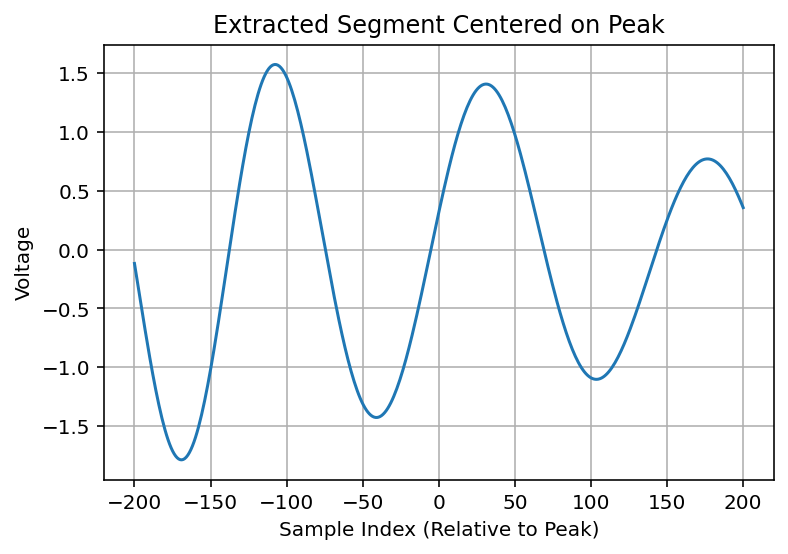

In [111]:
# Define the window size (100 samples before and 100 after the peak)
window_size = 200

# List to store the extracted segments
extracted_segments = []

# Loop through the sample_peaks array and extract the segments
for peak in sample_peaks:
    # Calculate start and end sample indices (100 before and 100 after)
    start_sample = peak - window_size
    end_sample = peak + window_size
    
    # Check if the indices are within bounds
    if start_sample < 0 or end_sample >= len(voltage_data):
        print(f"Skipping peak at sample {peak} due to out-of-bounds indexing.")
        continue
    
    # Extract the corresponding segment from the voltage data
    segment = preproc_sig2[start_sample:end_sample]
    
    # Append the extracted segment to the list
    extracted_segments.append(segment)

# Convert the list of segments to a NumPy array (optional)
extracted_segments_array = np.array(extracted_segments)

# Create the time axis based on the indices (sample points) around the peak
# We'll use the window size to create a range around the peak for the x-axis
time_axis = np.linspace(-window_size, window_size, 2 * window_size)

# Print the extracted segments (for verification)
print("Extracted Segments Shape:", extracted_segments_array.shape)

# Optionally, you can also visualize one of the segments
plt.plot(time_axis, extracted_segments_array[0])  # Plot the first extracted segment
plt.title("Extracted Segment Centered on Peak")
plt.xlabel("Sample Index (Relative to Peak)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


Extracted Segments Shape: (10, 400)


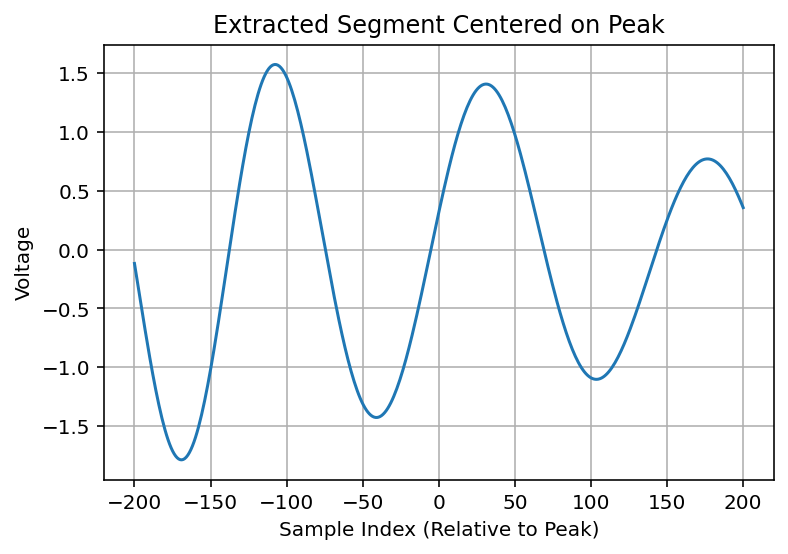

In [111]:
# Define the window size (100 samples before and 100 after the peak)
window_size = 200

# List to store the extracted segments
extracted_segments = []

# Loop through the sample_peaks array and extract the segments
for peak in sample_peaks:
    # Calculate start and end sample indices (100 before and 100 after)
    start_sample = peak - window_size
    end_sample = peak + window_size
    
    # Check if the indices are within bounds
    if start_sample < 0 or end_sample >= len(voltage_data):
        print(f"Skipping peak at sample {peak} due to out-of-bounds indexing.")
        continue
    
    # Extract the corresponding segment from the voltage data
    segment = preproc_sig2[start_sample:end_sample]
    
    # Append the extracted segment to the list
    extracted_segments.append(segment)

# Convert the list of segments to a NumPy array (optional)
extracted_segments_array = np.array(extracted_segments)

# Create the time axis based on the indices (sample points) around the peak
# We'll use the window size to create a range around the peak for the x-axis
time_axis = np.linspace(-window_size, window_size, 2 * window_size)

# Print the extracted segments (for verification)
print("Extracted Segments Shape:", extracted_segments_array.shape)

# Optionally, you can also visualize one of the segments
plt.plot(time_axis, extracted_segments_array[0])  # Plot the first extracted segment
plt.title("Extracted Segment Centered on Peak")
plt.xlabel("Sample Index (Relative to Peak)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


Extracted Segments Shape: (10, 400)


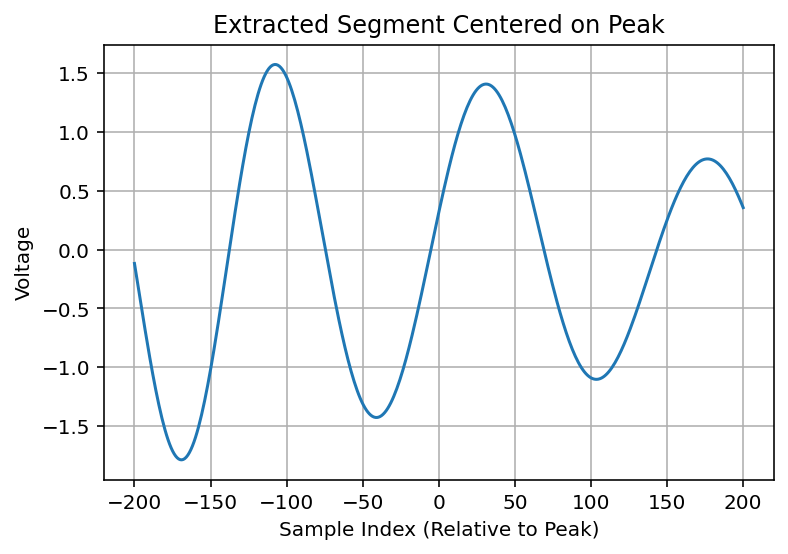

In [111]:
# Define the window size (100 samples before and 100 after the peak)
window_size = 200

# List to store the extracted segments
extracted_segments = []

# Loop through the sample_peaks array and extract the segments
for peak in sample_peaks:
    # Calculate start and end sample indices (100 before and 100 after)
    start_sample = peak - window_size
    end_sample = peak + window_size
    
    # Check if the indices are within bounds
    if start_sample < 0 or end_sample >= len(voltage_data):
        print(f"Skipping peak at sample {peak} due to out-of-bounds indexing.")
        continue
    
    # Extract the corresponding segment from the voltage data
    segment = preproc_sig2[start_sample:end_sample]
    
    # Append the extracted segment to the list
    extracted_segments.append(segment)

# Convert the list of segments to a NumPy array (optional)
extracted_segments_array = np.array(extracted_segments)

# Create the time axis based on the indices (sample points) around the peak
# We'll use the window size to create a range around the peak for the x-axis
time_axis = np.linspace(-window_size, window_size, 2 * window_size)

# Print the extracted segments (for verification)
print("Extracted Segments Shape:", extracted_segments_array.shape)

# Optionally, you can also visualize one of the segments
plt.plot(time_axis, extracted_segments_array[0])  # Plot the first extracted segment
plt.title("Extracted Segment Centered on Peak")
plt.xlabel("Sample Index (Relative to Peak)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


In [92]:
sample_peaks = np.array([467207, 467106, 467369, 549249, 950185, 507112, 900207, 257434, 18855, 1300753])

[[ 0.32259645  0.30824586  0.2933777  ...  1.4757112   1.46450635
   1.45200384]
 [ 0.22363833  0.2443074   0.26511159 ...  0.51195533  0.53696504
   0.5605078 ]
 [ 0.39806361  0.42852084  0.45768879 ...  0.0369136   0.07669258
   0.11568048]
 ...
 [ 0.24262865  0.29945583  0.35373327 ... -0.05784799 -0.07797443
  -0.09790132]
 [ 0.96735155  1.03482327  1.09918551 ...  0.16692185  0.1629967
   0.15887824]
 [-0.3879507  -0.38511227 -0.38130766 ...  1.02054806  1.00640781
   0.99220969]]


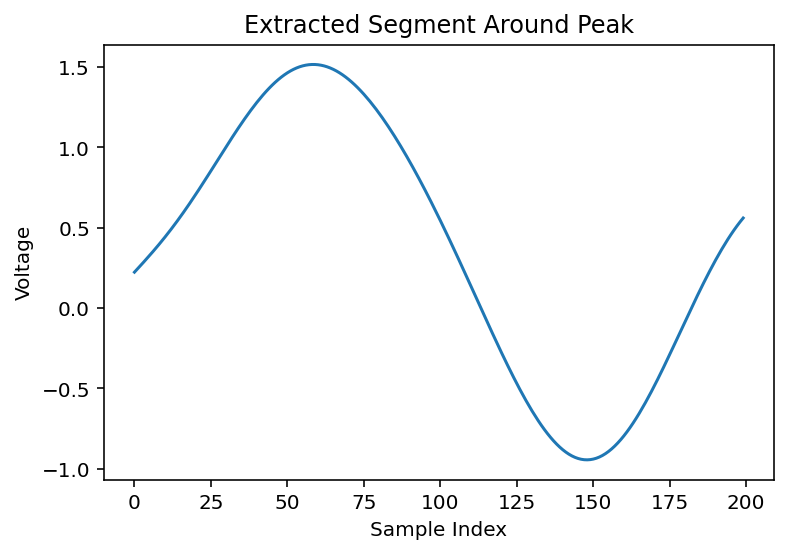

In [88]:
# Define the window size (10 samples before and 10 after the peak)
window_size = 100

# List to store the extracted segments
extracted_segments = []

# Loop through the filtered DataFrame and extract the segments based on 'sample_peak'
for _, row in burst_df.iterrows():
    sample_peak = row['sample_peak']
    
    # Calculate start and end sample indices (10 before and 10 after)
    start_sample = sample_peak - window_size
    end_sample = sample_peak + window_size
    
    # Extract the corresponding segment from the voltage data
    segment = voltage_data[start_sample:end_sample]
    
    # Append the extracted segment to the list
    extracted_segments.append(segment)

# Convert the list of segments to a NumPy array (optional)
extracted_segments_array = np.array(extracted_segments)

# Print the extracted segments (for verification)
print(extracted_segments_array)

# Optionally, you can also visualize one of the segments
import matplotlib.pyplot as plt
plt.plot(extracted_segments_array[1])  # Plot the first extracted segment
plt.title("Extracted Segment Around Peak")
plt.xlabel("Sample Index")
plt.ylabel("Voltage")
plt.show()

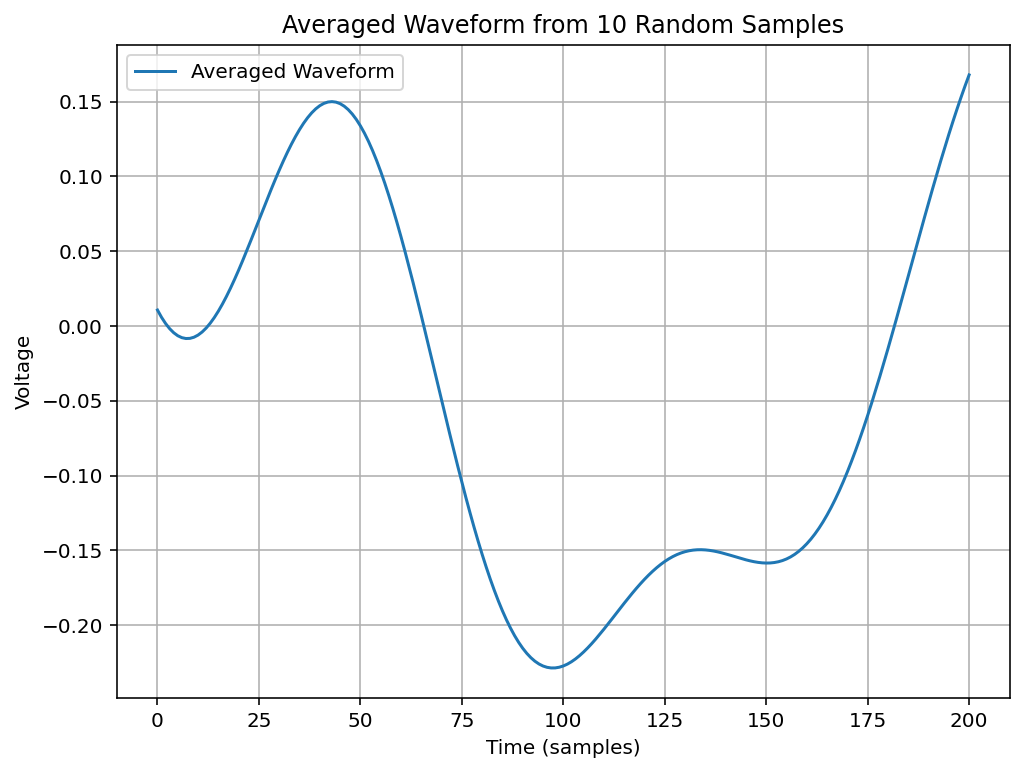

In [57]:
def plot_averaged_waveform(segments, num_samples=10):
    """
    Plot the averaged waveform from a random selection of voltage segments.

    Parameters:
        segments (pd.DataFrame): DataFrame of voltage segments.
        num_samples (int): Number of random samples to average.

    Returns:
        None
    """
    # Randomly sample 10 segments
    selected_segments = segments.sample(n=num_samples, random_state=42)  # Random state for reproducibility

    # Compute the average across selected segments
    averaged_waveform = selected_segments.mean(axis=0)

    # Plot the averaged waveform
    plt.figure(figsize=(8, 6))
    plt.plot(averaged_waveform, label='Averaged Waveform')
    plt.xlabel('Time (samples)')
    plt.ylabel('Voltage')
    plt.title(f'Averaged Waveform from {num_samples} Random Samples')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_averaged_waveform(segments, num_samples=10)

In [34]:
#combine all data into a single data frame
df_bycycle_2ByPost['time'] = 'Post'
df_bycycle_2ByPost['group'] = 'Bystander'

df_bycycle_2ByPre['time'] = 'Pre'
df_bycycle_2ByPre['group'] = 'Bystander'

df_bycycle_2Post['time'] = 'Post'
df_bycycle_2Post['group'] = 'Mouse'

df_bycycle_2Pre['time'] = 'Pre'
df_bycycle_2Pre['group'] = 'Mouse'

all_data = pd.concat([df_bycycle_2ByPost, df_bycycle_2ByPre, df_bycycle_2Post, df_bycycle_2Pre])


                            OLS Regression Results                            
Dep. Variable:              time_peak   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     433.7
Date:                Sat, 04 Jan 2025   Prob (F-statistic):          8.06e-277
Time:                        18:01:01   Log-Likelihood:            -1.6814e+05
No. Observations:               35835   AIC:                         3.363e+05
Df Residuals:                   35831   BIC:                         3.363e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [233]:
# Specify the breathing variables of interest
breathing_variables = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak']  # Include dyad_id in the selection

#mouse id - bystander in exp 1 is mouse 2 
#group - Bystander = 2

# Filter and combine dataframes
df_bycycle_ByPost = df_bycycle_ByPost[breathing_variables].copy()
df_bycycle_ByPost['time'] = 2
df_bycycle_ByPost['group'] = 2
df_bycycle_ByPost['experiment'] = 1
df_bycycle_ByPost['mouse_id'] = 2

df_bycycle_ByPre = df_bycycle_ByPre[breathing_variables].copy()
df_bycycle_ByPre['time'] = 1
df_bycycle_ByPre['group'] = 2
df_bycycle_ByPre['experiment'] = 1
df_bycycle_ByPre['mouse_id'] = 2

df_bycycle_Post = df_bycycle_Post[breathing_variables].copy()
df_bycycle_Post['time'] = 2
df_bycycle_Post['group'] = 1
df_bycycle_Post['experiment'] = 1
df_bycycle_Post['mouse_id'] = 1

df_bycycle_Pre = df_bycycle_Pre[breathing_variables].copy()
df_bycycle_Pre['time'] = 1
df_bycycle_Pre['group'] = 1
df_bycycle_Pre['experiment'] = 1
df_bycycle_Pre['mouse_id'] = 1

df_bycycle_2ByPost = df_bycycle_2ByPost[breathing_variables].copy()
df_bycycle_2ByPost['time'] = 2
df_bycycle_2ByPost['group'] = 2
df_bycycle_2ByPost['experiment'] = 2
df_bycycle_2ByPost['mouse_id'] = 1

df_bycycle_2ByPre = df_bycycle_2ByPre[breathing_variables].copy()
df_bycycle_2ByPre['time'] = 1
df_bycycle_2ByPre['group'] = 2
df_bycycle_2ByPre['experiment'] = 2
df_bycycle_2ByPre['mouse_id'] = 1

df_bycycle_2Post = df_bycycle_2Post[breathing_variables].copy()
df_bycycle_2Post['time'] = 2
df_bycycle_2Post['group'] = 1
df_bycycle_2Post['experiment'] = 2
df_bycycle_2Post['mouse_id'] = 2

df_bycycle_2Pre = df_bycycle_2Pre[breathing_variables].copy()
df_bycycle_2Pre['time'] = 1
df_bycycle_2Pre['group'] = 1
df_bycycle_2Pre['experiment'] = 2
df_bycycle_2Pre['mouse_id'] = 2

# Combine all filtered data
all_data = pd.concat([df_bycycle_2ByPost, df_bycycle_2ByPre, df_bycycle_2Post, df_bycycle_2Pre, df_bycycle_ByPost, df_bycycle_ByPre, df_bycycle_Post, df_bycycle_Pre], ignore_index=True)
print(all_data)

       time_rdsym  time_ptsym  period  time_trough  time_rise  time_decay  \
0        0.509434    0.481481     106           56         54          52   
1        0.442308    0.510000     104           49         46          58   
2        0.555556    0.492754     135           70         75          60   
3        0.527273    0.486486     110           57         58          52   
4        0.470085    0.531532     117           52         55          62   
...           ...         ...     ...          ...        ...         ...   
75273    0.350000    0.611940     160           52         56         104   
75274    0.980000    0.203883      50           82         49           1   
75275    0.472868    0.558659     258           79        122         136   
75276    0.338462    0.286822      65           92         22          43   
75277    0.364103    0.655405     195           51         71         124   

       time_peak  time  group  experiment  mouse_id  
0             52     

In [241]:
#aggregated_data = all_data.groupby(['group', 'time', 'experiment', 'mouse_id'])['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak'].mean().reset_index()
print(aggregated_data)
aggregated_data.to_csv('/Users/elizabethkaplan/Desktop/Voytek/MousePain/DYAAD1EXP1/ALL_DATA_ANOVA.txt', sep='\t', index=False)

#print(aggregated_data.dtypes)
#print(aggregated_data.isnull().sum())  # Check for missing values

   group  time  experiment  mouse_id  time_rdsym  time_ptsym      period  \
0      1     1           1         1    0.476852    0.507830  132.407593   
1      1     1           2         2    0.499207    0.508326  132.285399   
2      1     2           1         1    0.446080    0.498864  147.838426   
3      1     2           2         2    0.488430    0.504269  148.524096   
4      2     1           1         2    0.496057    0.500122  133.960994   
5      2     1           2         1    0.477018    0.507883  125.495607   
6      2     2           1         2    0.485540    0.498445  130.841233   
7      2     2           2         1    0.481406    0.511526  124.967021   

   time_trough  time_rise  time_decay  time_peak  
0    65.184520  61.949529   70.458064  67.217187  
1    64.705558  65.908028   66.377371  67.578297  
2    74.132660  65.431986   82.406440  73.708559  
3    73.374649  72.349810   76.174286  75.149695  
4    67.038261  66.355962   67.605032  66.921989  
5    61.6

In [255]:

# Perform the repeated measures ANOVA
dv_list = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak']


#aggregated_data['group'] = aggregated_data['group'].astype('category')
#aggregated_data['time'] = aggregated_data['time'].astype('category')
#aggregated_data['experiment'] = aggregated_data['experiment'].astype('category')

# Perform the repeated measures ANOVA for each dependent variable
for dv in dv_list:
    print(f"Running ANOVA for {dv}")
    
    # Fit the model
    model = smf.ols(f'{dv} ~ C(group) * C(time) + C(experiment)', data=aggregated_data).fit()
    
    # Perform the ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Print the results for each dependent variable
    print(anova_table)
    print("\n" + "="*50 + "\n")

Running ANOVA for time_rdsym
                    sum_sq   df         F    PR(>F)
C(group)          0.000108  1.0  0.290198  0.627500
C(time)           0.000284  1.0  0.760574  0.447331
C(experiment)     0.000216  1.0  0.577110  0.502690
C(group):C(time)  0.000157  1.0  0.419774  0.563216
Residual          0.001121  3.0       NaN       NaN


Running ANOVA for time_ptsym
                        sum_sq   df         F    PR(>F)
C(group)          2.154869e-07  1.0  0.015768  0.908015
C(time)           1.528200e-05  1.0  1.118223  0.367918
C(experiment)     8.939537e-05  1.0  6.541289  0.083389
C(group):C(time)  2.807881e-05  1.0  2.054599  0.247196
Residual          4.099897e-05  3.0       NaN       NaN


Running ANOVA for period
                      sum_sq   df          F    PR(>F)
C(group)          262.098063  1.0  26.560026  0.014164
C(time)            98.148338  1.0   9.945981  0.051118
C(experiment)      23.722696  1.0   2.403968  0.218812
C(group):C(time)  155.919065  1.0  15.800248 

In [254]:
# Post-hoc pairwise comparisons for 'group'
#posthoc_group = pg.pairwise_ttests(dv='period', between='group', data=aggregated_data, padjust='bonferroni')
#print(posthoc_group)

# Post-hoc pairwise comparisons for interaction 'group * time'
posthoc_group_time = pg.pairwise_ttests(dv='period', between=['group', 'time'], data=aggregated_data, padjust='bonferroni')
print(posthoc_group_time)

       Contrast group    A    B Paired  Parametric          T  dof  \
0         group     -  1.0  2.0  False        True   2.261827  6.0   
1          time     -  1.0  2.0  False        True  -1.117759  6.0   
2  group * time     1    1    2  False        True -45.471284  2.0   
3  group * time     2    1    2  False        True   0.354076  2.0   

  alternative     p-unc    p-corr    p-adjust    BF10     hedges  
0   two-sided  0.064386       NaN         NaN   1.656   1.390742  
1   two-sided  0.306417       NaN         NaN   0.741  -0.687282  
2   two-sided  0.000483  0.000967  bonferroni  18.621 -25.983591  
3   two-sided  0.757127  1.000000  bonferroni   0.639   0.202329  


/Users/elizabethkaplan/opt/anaconda3/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [176]:
pip install pingouin


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [182]:
print(all_data.dtypes)
# Check for any NaN or infinite values in the relevant columns
print(all_data[['time', 'period', 'dyad_ID']].isna().sum())  # Check for NaNs
print((all_data[['time', 'period', 'dyad_ID']] == float('inf')).sum())

time_rdsym     float64
time_ptsym     float64
period           int64
time_trough      int64
time             int64
group           object
dyad_ID          int64
dtype: object
time       0
period     0
dyad_ID    0
dtype: int64
time       0
period     0
dyad_ID    0
dtype: int64


In [244]:
#import pingouin as pg

# Perform repeated measures ANOVA
anova_results = pg.rm_anova(
    data=aggregated_data,
    dv='period',              # Dependent variable
    within=['time', 'group'],          # Only include 'time' as within-subject factor
    subject='mouse_id',       # Unique identifier for subjects
    detailed=True,
    numeric_only=False
)

print(anova_results)       # Identifier for the dyads

TypeError: rm_anova() got an unexpected keyword argument 'numeric_only'

In [189]:
pip install --upgrade pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Example: Linear regression to analyze 'period'
# Convert categorical variables into numeric factors for the regression
all_data['time'] = all_data['time'].astype('category')
all_data['group'] = all_data['group'].astype('category')

# Define the formula for regression
# Example for 'period' variable
formula = 'time_peak ~ C(time) + C(group) + C(time):C(group)'

# Fit the model
model = smf.ols(formula, data=all_data).fit()

# Print the summary of the regression model
print(model.summary())

In [ ]:
##Repeated Measures ANOVA 




In [211]:
%matplotlib qt

In [214]:
# Plot bursts
plot_burst_detect_summary(df_bycycle_2Post, preproc_sig, fs, threshold_kwargs)

In [127]:
df_bycycle_Post_NaN = df_bycycle_Post.fillna(0)

result = df.pivot(index='time_',columns='time_ptsym',values='volt_amp')

In [36]:
## HEATMAP CORRELATION 

subset_data = df_bycycle_Post_NaN.iloc[:, :17]  # Select the first 17 columns
# Exclude specific columns by name, e.g., 'volt'
columns_to_exclude = ['volt_decay', 'volt_rise', 'volt_amp', 'volt_peak', 'volt_trough', 'amp_fraction']  # List of columns to exclude
subset_data = subset_data.drop(columns=columns_to_exclude, errors='ignore')  # Exclude specified columns
correlation_matrix = subset_data.corr()  # Compute correlation for the subset

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

NameError: name 'df_bycycle_Post_NaN' is not defined

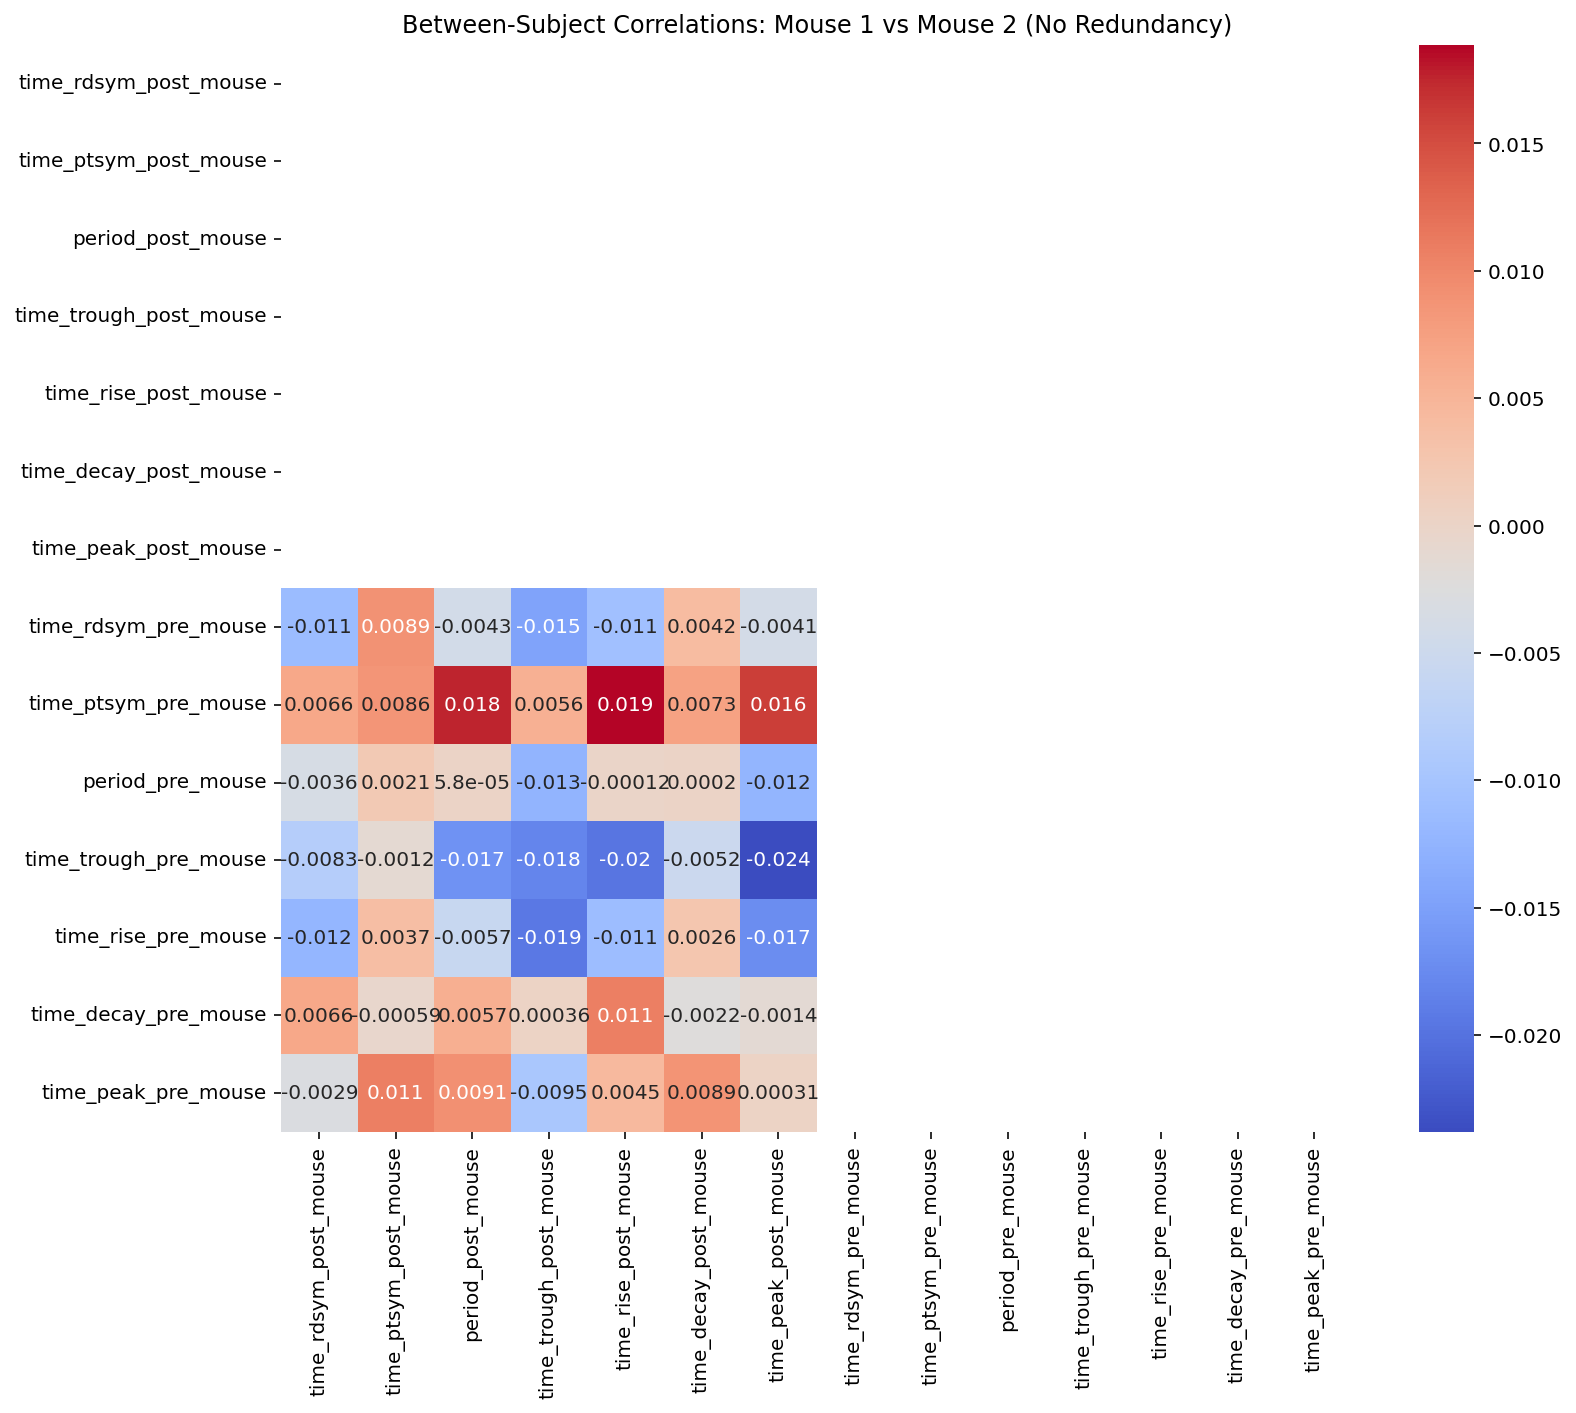

In [52]:
##HEATMAPS PT2

variables_to_include = ['time_rdsym', 'time_ptsym', 'period', 'time_trough', 'time_rise', 'time_decay', 'time_peak']  

# Subset data for each mouse
post_mouse = df_bycycle_2Post[variables_to_include]
pre_mouse = df_bycycle_2Pre[variables_to_include]

# Rename columns to distinguish between mice
post_mouse.columns = [f"{col}_post_mouse" for col in post_mouse.columns]
pre_mouse.columns = [f"{col}_pre_mouse" for col in pre_mouse.columns]

# Step 2: Combine the data from both mice
combined_data = pd.concat([post_mouse, pre_mouse], axis=1)

# Step 3: Compute correlation matrix
correlation_matrix = combined_data.corr()

# Step 4: Create a mask to exclude within-subject correlations
mask = np.zeros_like(correlation_matrix, dtype=bool)  # Initialize a full matrix of False
columns_mouse1 = post_mouse.columns
columns_mouse2 = pre_mouse.columns

# Mask Mouse 1 vs Mouse 1 and Mouse 2 vs Mouse 2 correlations
for col1 in columns_mouse1:
    for col2 in columns_mouse1:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True
for col1 in columns_mouse2:
    for col2 in columns_mouse2:
        mask[correlation_matrix.index == col1, correlation_matrix.columns == col2] = True

# Mask the upper triangle of the correlation matrix
upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask |= upper_triangle  # Combine both masks using logical OR

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', cbar=True)
plt.title("Between-Subject Correlations: Mouse 1 vs Mouse 2 (No Redundancy)")
plt.show()

In [46]:
# Number of bursts
num_bursts = df_bycycle_ByPre['is_burst'].sum()

# Total number of cycles
total_cycles = len(df_bycycle_ByPre)

# Print the results
print(f"Number of bursts: {num_bursts}")
print(f"Total number of cycles: {total_cycles}")
print(f"Percentage of cycles in bursts: {num_bursts / total_cycles * 100:.2f}%")

Number of bursts: 2999
Total number of cycles: 6717
Percentage of cycles in bursts: 44.65%


# print(df_bycycle_Pre)

# Specify the directory and filename
output_path = '/Users/elizabethkaplan/Desktop/Voytek/MousePain/Bycycle_DYAD1EXP1ByMousePre'  # Replace with your desired path

# Ensure the array is of float type
df_bycycle = df_bycycle.astype(float)

# Save the array to the specified directory
np.save(output_path, df_bycycle_ByPre)

In [40]:
df_bycycle

NameError: name 'df_bycycle' is not defined

In [174]:
# Print the column names of the DataFrame
print(df_bycycle_ByPre.columns.tolist())


['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity', 'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough', 'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp', 'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak', 'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise', 'sample_last_trough', 'sample_next_trough', 'is_burst']


In [151]:
# Plot bursts
plot_burst_detect_summary(df_bycycle_2ByPre, filtered_sig, fs, threshold_kwargs, xlim=(0,5))

NameError: name 'filtered_sig' is not defined

In [112]:
feats_to_plot = {'volt_amp': 'Amplitude (μV)', 
                 'time_ptsym': 'Peak-Trough Asymmetry', 
                 'time_rdsym': 'Rise-Decay Asymmetry'}

def plot_violin_comparison(df1, df2, feats_to_plot):
    fig, axes = plt.subplots(1, len(feats_to_plot), figsize=(15, 5), sharey=True)
    
    for ax, (feat, title) in zip(axes, feats_to_plot.items()):
        data = [df1[feat], df2[feat]]
        ax.violinplot(data, showmeans=True)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Bystander Mouse Post', 'Mouse Post'])
        ax.set_ylabel(title)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

plot_violin_comparison(df_bycycle_ByPost, df_bycycle_Post, feats_to_plot)

In [145]:
def plot_waveform_features(df_bycycle, feats_to_plot):
    """Plot waveform shape features of interest, contrasting by one feature of interest (x).
    
     Parameters
    ----------
    df_bursts : pd.DataFrame
        DataFrame with shape (n_trials, n_features). Each row contains the computed features 
        for one trial.
    feats_to_plot : dict
        The features to plot, with keys being the name of the feature within df_bursts and the
        values being how the feature should be labeled on the y-axis of its corresponding 
        subplot.
    x : str
        The name of the contrast feature.
    """
    # Create subplots, one for each feature to plot
    fig, axes = plt.subplots(2, len(feats_to_plot)//2)
    
    for ax, (feat, title) in zip(axes.flatten(), feats_to_plot.items()):
        ax.violin plot(data, showmeans=True)
        ax.set_xticks(np.arange(1, 3))
        ax.set_xticklabels(labels=['Target', 'Non-Target'])
        ax.set_ylabel(title)
    plt.tight_layout()
    return

SyntaxError: invalid syntax (4169017562.py, line 20)

In [88]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # coonvert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

In [85]:
def compute_features_each_trial(erp, fs, band, threshold_kwargs):
    """Compute waveform shape features for each trial, averaging across cycles within one trial. 
    
    Parameters
    ----------
    erp : array-like 2d
        Windowed trial data of shape (num_trials, num_timepts). 
    fs : float
        Data sampling rate (Hz).
    band : tuple
        Band of interest, defined by (f_min, f_max).
    threshold_kwargs : tuple of float/int
        Keyword arguments to be passed to bycycle.
    trial_mean : bool, optional (default: True)
        if True, compute the mean features for cycles within the same trial.
    
    Returns
    -------
    df_bursts : pd.DataFrame
        DataFrame with shape (n_trials, n_features). Each row contains the computed features 
        for one trial.
    """
    # Compute features
    df_bycycle = flatten_dfs(compute_features_2d(erp, fs, alpha_band, compute_features_kwargs={
        'threshold_kwargs': threshold_kwargs}), np.arange(erp.shape[0]))
    
    # Calculate asymmetry
    sym_feats = [feat for feat in df_bycycle.columns if 'sym' in feat]
    for feat in sym_feats:
        df_bycycle[feat.replace('sym', 'asym')] = np.abs(df_bycycle[feat] - 0.5) 
    
    # Calculate frequency
    df_bycycle['freq'] = fs / df_bycycle['period'] 
    
    # Just get bursts
    df_bursts = df_bycycle.query('is_burst')
    
    # Take average for each trial
    df_bursts = df_bursts.groupby('Label').mean()
    return df_bursts

In [112]:
# Compute features for each trial
df_bursts_sta = compute_features_each_trial(filtered_sig, fs, alpha_band, threshold_kwargs)
print(df_bursts_sta)

# Combine DataFrames for target and non-target ("standard")
#df_bursts_sta['stim'] = 'non-target'
#df_bursts_tar['stim'] = 'target'
#df_bursts = pd.concat([df_bursts_sta, df_bursts_tar])

TypeError: object of type 'numpy.float64' has no len()

In [30]:
scaled_data = data * 100

# Find the maximum and minimum values in the data
max_value = np.max(scaled_data)
min_value = np.min(scaled_data)

print(max_value)
print(min_value)

522.78730757689
-363.26211518761


In [25]:
# Create a time vector
n_samples = data.shape[0]  
time_vector = np.arange(n_samples) / fs 

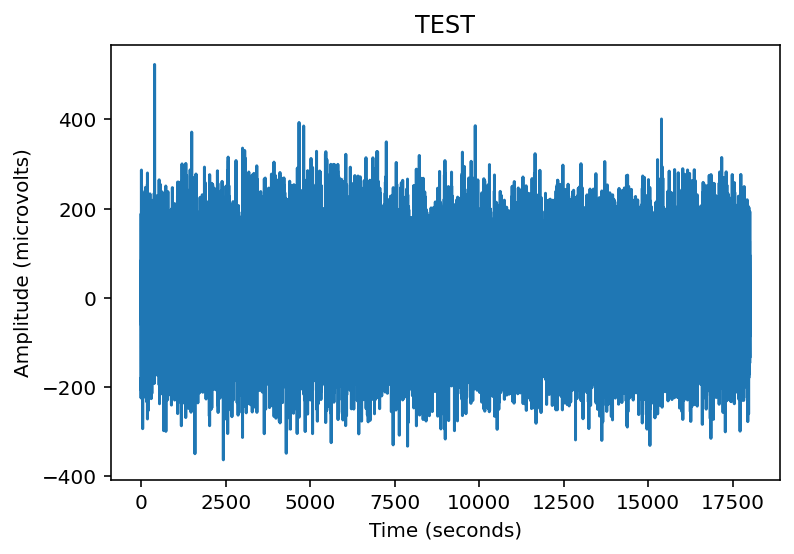

In [31]:
# Plot 
import matplotlib.pyplot as plt
plt.plot(time_vector, scaled_data)  
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (microvolts)')
plt.title('TEST')
plt.show()

In [32]:
# Bandpass filter from 0.5 to 3x alpha band
filtered_sig = filter_signal(scaled_data, fs, 'lowpass', 3 * alpha_band[-1], remove_edges=False)

# Plot filtered signal
times = create_times(len(filtered_sig) / fs, fs)
plot_time_series(times, filtered_sig, xlim=(0, 5))

NameError: name 'alpha_band' is not defined

In [51]:
## POWER SPECTRAL ANALYSIS 

def plot_signal_and_power(time, signal, freq, spectrum, title='', logscale=False, xlims=None):
    '''
    Plot time-series and corresponding power spectum

    Parameters
    ----------
    time : 1D array, float
        time-vector for signal
    signal : 1D array, float
        time-series e.g. LFP or EEG
    freq : 1D array, float
        frequency-vector for spectrum
    spectrum : 1D array, float
        power spectrum of signal
    title : str, optional
        figure title. The default is ''.
    logscale : bool, optional
        whether to plot the spectrum in log-log space. The default is False.
    xlims : 1D array (len=2), optional
        x-axis limits for time-series plot ([lower_limit, upper_limit]). 
        The default is None.

    '''
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
    fig.suptitle(title)

    # plot signal
    ax1.set(xlabel='time (s)', ylabel='voltage (au)', title='Time-series')
    ax1.plot(time, signal)
    if xlims:
        ax1.set_xlim(xlims)
        
    # plot spectra
    ax2.set(xlabel='frequency (Hz)', ylabel='power (au)', title='Power Spectral Density')
    ax2.plot(freq, spectrum);
    ax2.set_xlim([.1,200])
    if logscale:
        ax2.set(xscale='log', yscale='log')

In [48]:
# general 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Voytek Lab tools
from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim
from neurodsp import utils
from neurodsp import plts

In [52]:
# signal params
N_SECONDS = 1800000 # signal duration
FS = 100 # sampling frequency

ValueError: x and y must have same first dimension, but have shapes (180000000,) and (1800000,)

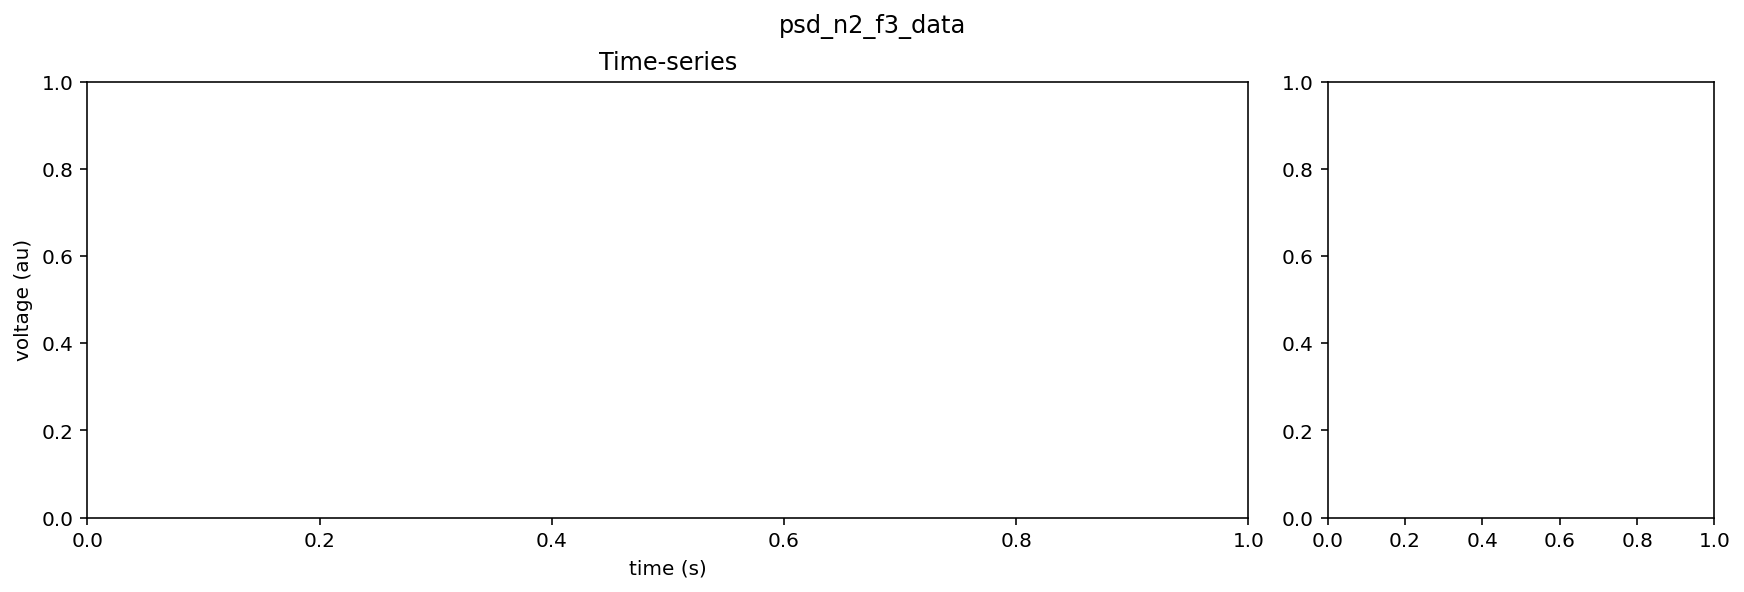

In [55]:
time = utils.create_times(N_SECONDS, FS, start_val=-N_SECONDS/2)

# compute power spectrum
freq, psd_scaled_data = spectral.compute_spectrum(scaled_data, fs)

# plot
plot_signal_and_power(time, scaled_data, freq, psd_scaled_data, title='psd_n2_f3_data')

In [45]:
print(len(scaled_data))

1800000
